# LMfit.jl demonstration

2024_10_15: IBS

This notebook demonstrates the current functionality of the `LMfit.jl` package.  This package is patterned after the wonderful `lmfit` python package; I currently implement only a tiny subset of the features of the original Python version: specifically those features that I use...  As I encounter needed features I will move them over.

In general the syntax is similar enough to `lmfit.py`, but owing to differences between Julia and Python, the interface is not identical. 

TODO: keyword argument passing is not demo'ed

## Basic setup

In [1]:
using Pkg
if isfile("Project.toml")
    Pkg.activate(".")
end

Pkg.resolve()
Pkg.instantiate()
Pkg.update()
Pkg.precompile()

using LaTeXStrings # Because of the l"" syntax
using Revise
using CairoMakie
using LMfit
using LazyGrids

  Activating project at `~/Julia/LMfit/notebooks`
  No Changes to `~/Julia/LMfit/notebooks/Project.toml`
  No Changes to `~/Julia/LMfit/notebooks/Manifest.toml`
Precompiling project...
    819.6 ms  ✓ LMfit
  1 dependency successfully precompiled in 2 seconds. 307 already precompiled.
    Updating registry at `~/.julia/registries/General.toml`
   Installed Tables ─ v1.12.1
  No Changes to `~/Julia/LMfit/notebooks/Project.toml`
    Updating `~/Julia/LMfit/notebooks/Manifest.toml`
  [bd369af6] ↑ Tables v1.12.0 ⇒ v1.12.1
Precompiling project...
    470.1 ms  ✓ Tables
    626.3 ms  ✓ StructArrays
    437.8 ms  ✓ StructArrays → StructArraysAdaptExt
    385.6 ms  ✓ StructArrays → StructArraysLinearAlgebraExt
    493.1 ms  ✓ StructArrays → StructArraysSparseArraysExt
    579.0 ms  ✓ StructArrays → StructArraysStaticArraysExt
  56559.6 ms  ✓ Makie
  20670.6 ms  ✓ CairoMakie
  8 dependencies successfully precompiled in 79 seconds. 300 already precompiled.


## Direct usage

I am going to start with the most literal possible implementation before introducing convenance features.

We begin by defining an objective function---in this case a simple Gaussian---evaluate the function and generate fake, noisy, data.  Then I plot this to see what we are after.

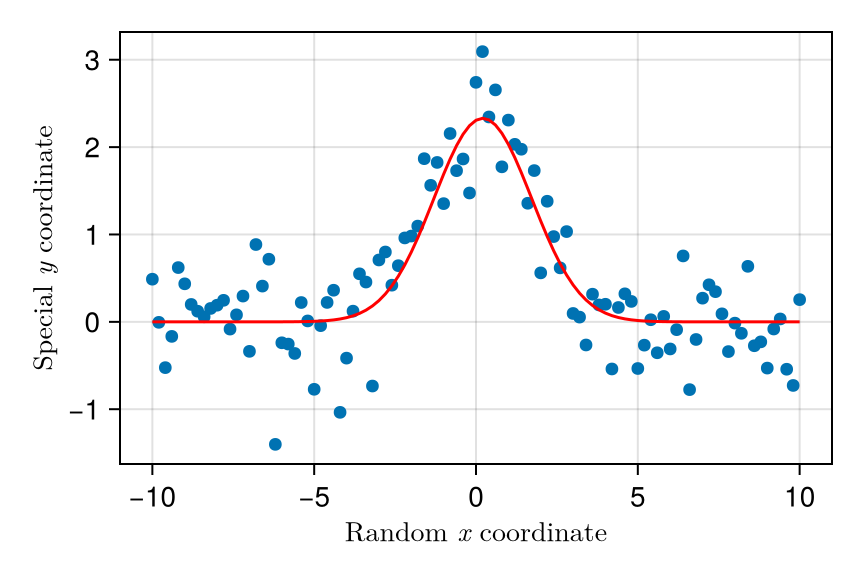

In [2]:
gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))

x = range(-10, 10, length=101)
y = gaussian(x, 2.33, 0.21, 1.51)
y_noise = y .+ 0.5 .* randn(size(x))

f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

Now we define a model and the associatd parameters

In [3]:
# We are creating a model from the function.  Because of the multiple dispatch system, we need to 
# manually specify what args and kwargs are for the specific method we want to use
m  = Model(gaussian, [:x, :amp, :cen, :wid]; var_names=[:x])

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen; value=0.0, min=-5.0, max=5.0)
add!(ps, :wid; value=1.0)

# Generate data from the model before and after the fit
mr = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(mr.ps_best; x=x)
println("Final parameters: $(mr.ps_best)")


Final parameters: Parameters:
	Parameter with uncertainty: amp	value=2.4045840565483645	σ=0.32898551548414834	min=-Inf	max=Inf
	Parameter with uncertainty: cen	value=0.15630617074498343	σ=0.24705801409110675	min=-Inf	max=Inf
	Parameter with uncertainty: wid	value=1.5638416073663137	σ=0.24705801409470654	min=-Inf	max=Inf



Great!  We have setup the model, linked variables, fit the model, and evaluated the model as a function.  The final stage is to plot the results!

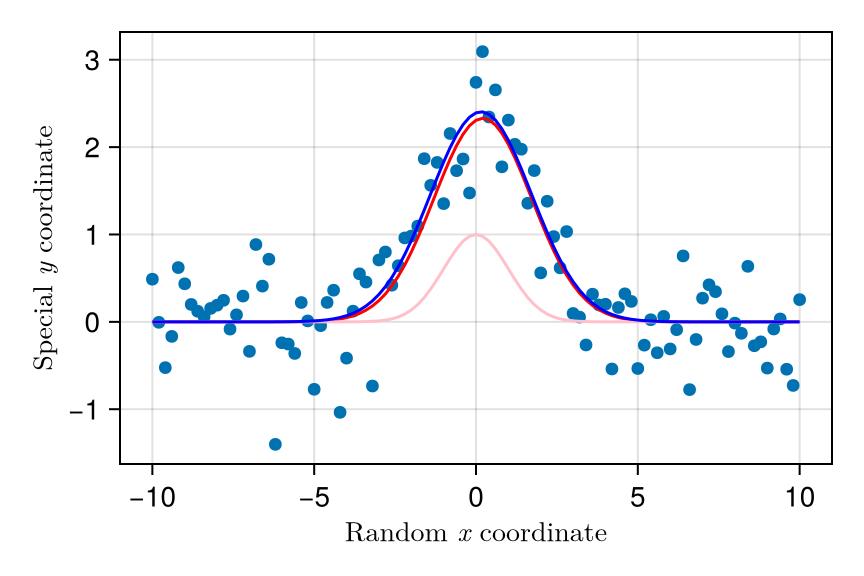

In [4]:
f = Figure(size=(6,4).*72)
ax = Axis(f[1,1])
plot!(ax, x, y_noise)
lines!(ax, x, y, color=:red)
lines!(ax, x, y_model, color=:pink)
lines!(ax, x, y_fit, color=:blue)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Special $y$ coordinate"

f

## Simplified usage

When the function is defined locally, the process can be simplified via the `@generate_model` macro.  This works with the function definition to initialize the model.  Notice that this cannot distinguish parameters from independent variables, so we need to specify the variables.  Once the independent variable is defined we can ask the model to automatically generate parameters, but parameters need to be specified. 

In [5]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)

# Create parameters automatically (very little behefit here except for error checking)
ps = make_params(m; amp=(value=1.0, min=0.0, max=5.0), cen=(value=0.0, min=-5.0, max=5.0), wid=1.0)

# Generate data from model
y_model = m(ps; x=x)

# Generate data from the model before and after the fit
mr = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(mr.ps_best; x=x)
println("Final parameters: $(mr.ps_best)")

Final parameters: Parameters:
	Parameter with uncertainty: amp	value=2.4045840565483645	σ=0.32898551548414834	min=-Inf	max=Inf
	Parameter with uncertainty: cen	value=0.15630617074498343	σ=0.24705801409110675	min=-Inf	max=Inf
	Parameter with uncertainty: wid	value=1.5638416073663137	σ=0.24705801409470654	min=-Inf	max=Inf



Great!!  So far I have created a model and the associated parameters, and can evaluate the model for the desired parameters, including a form suitable for fitting.

Next I demonstrate a fit with an algebraic relation

In [6]:
# Define an objective function
m = @generate_model gaussian(x, amp, cen, wid) = @. amp * exp(-(x - cen)^2 / (2 * wid^2))
update_vars!(m, :x)

# Create parameters automatically
ps = make_params(m; amp=2.33, cen=0.21, wid=1.51)
ps[:wid] = Expression(ps[:wid]; expr=:(cen .* amp))

# Generate data from the model before and after the fit
mr = fit(m, y_noise, ps; x=x)
y_model = m(ps; x=x)
y_fit = m(mr.ps_best; x=x)
println("Final parameters: $(mr.ps_best)")

Final parameters: Parameters:
	Parameter with uncertainty: amp	value=2.613975000113675	σ=0.30888781998077525	min=-Inf	max=Inf
	Parameter with uncertainty: cen	value=0.5311070894255496	σ=0.11471006268148139	min=-Inf	max=Inf
	Expression: wid	expr=cen .* amp	value=1.3883006541415246



## Higher dimensional data

One of the most significant motivations for this package is the transparent handling of higher dimensional data.  Let us now consider fitting to a 2D Gaussian, and as before I will start by creating the noisy data to fit to.

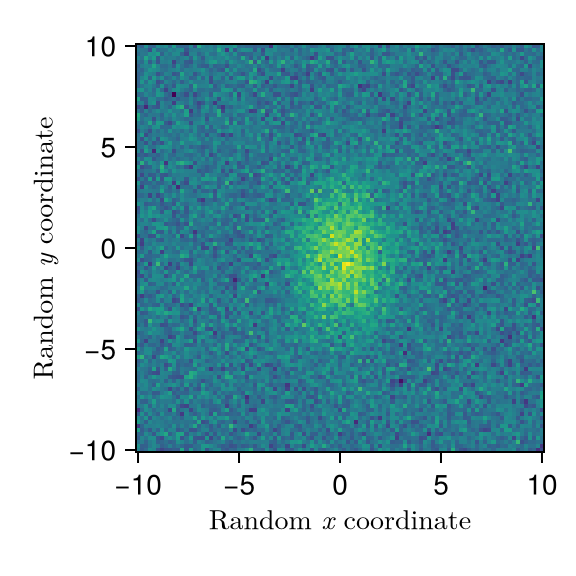

In [7]:
# Define an objective function
m = @generate_model gaussian2D(x, y, amp, cen_x, cen_y, wid_x, wid_y) = @. amp * exp(-(x - cen_x)^2 / (2 * wid_x^2)-(y - cen_y)^2 / (2 * wid_y^2) )

x = range(-10, 10, length=101)
y = range(-10, 10, length=101)
(xgrid, ygrid) = ndgrid(x, y) # using LazyGrids

z = gaussian2D(xgrid, ygrid, 2.33, 0.21, -0.5, 1.51, 2.5)
z_noise = z .+ 0.5 .* randn(size(xgrid))

f = Figure(size=(4,4).*72)
ax = Axis(f[1,1], aspect=1)
heatmap!(ax, x, y, z_noise)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Random $y$ coordinate"

f

In [8]:
update_vars!(m, :x, :y)

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen_x; value=0.0, min=-5.0, max=5.0)
add!(ps, :cen_y; value=0.0, min=-5.0, max=5.0)
add!(ps, :wid_x; value=1.0)
add!(ps, :wid_y; value=1.0)

# Generate data from the model before and after the fit
mr = fit(m, z_noise, ps; x=xgrid, y=ygrid)
z_model = m(ps; x=xgrid, y=ygrid)
z_fit = m(mr.ps_best; x=xgrid, y=ygrid)
println("Final parameters: $(mr.ps_best)")

Final parameters: Parameters:
	Parameter with uncertainty: amp	value=2.321901701283247	σ=0.08289072766607464	min=-Inf	max=Inf
	Parameter with uncertainty: cen_x	value=0.1877418959810788	σ=0.05506120151385169	min=-Inf	max=Inf
	Parameter with uncertainty: cen_y	value=-0.4598358262352904	σ=0.08578410517747491	min=-Inf	max=Inf
	Parameter with uncertainty: wid_x	value=1.542352892642091	σ=0.05506120151384812	min=-Inf	max=Inf
	Parameter with uncertainty: wid_y	value=2.4029505966746525	σ=0.08578426599646653	min=-Inf	max=Inf



Since it is difficult to plot curves through data for 2D data, I will instead show the residuals.  This also serves to highlight the provided `residuals` function.

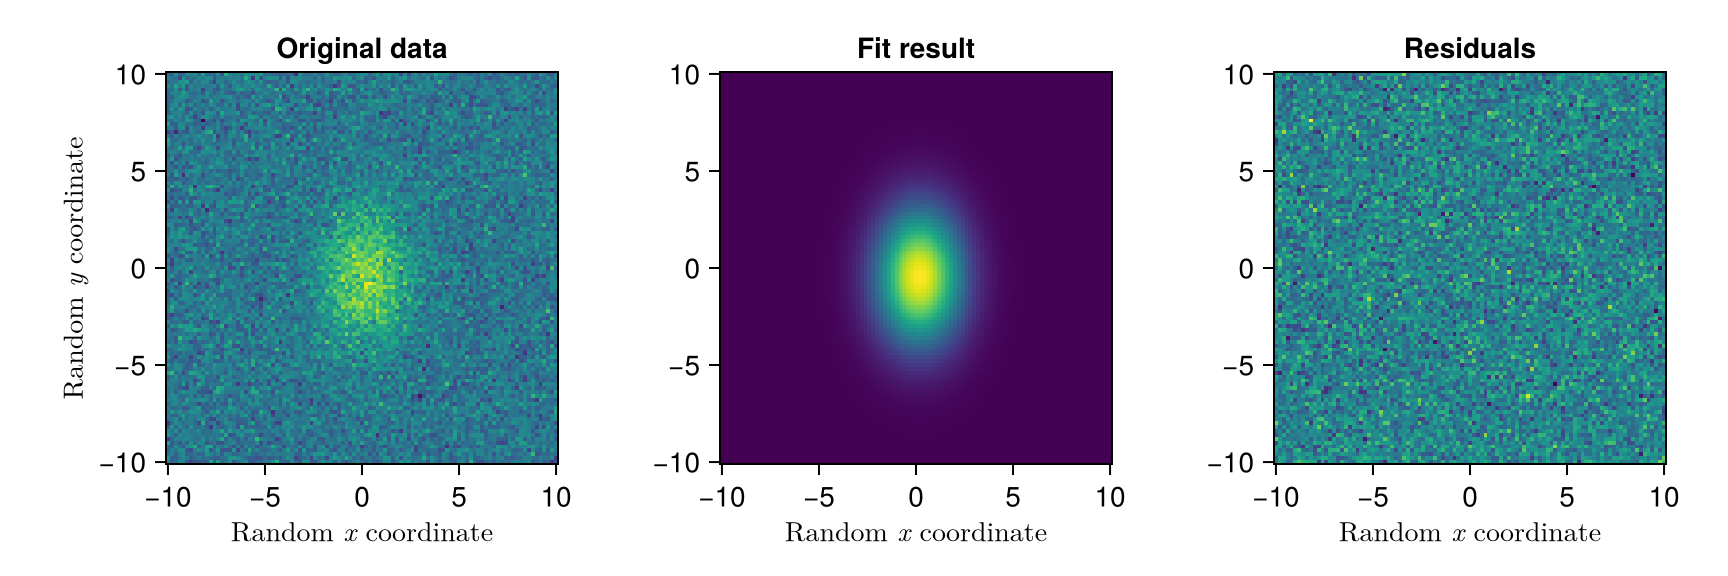

In [9]:
f = Figure(size=(12,4).*72)
ax = Axis(f[1,1], aspect=1, title="Original data")
heatmap!(ax, x, y, z_noise)

ax.xlabel = L"Random $x$ coordinate"
ax.ylabel = L"Random $y$ coordinate"

ax = Axis(f[1, 2], aspect=1, title="Fit result")
heatmap!(ax, x, y, z_fit)

ax.xlabel = L"Random $x$ coordinate"

ax = Axis(f[1, 3], aspect=1, title="Residuals")
heatmap!(ax, x, y, residuals(mr) )

ax.xlabel = L"Random $x$ coordinate"

f

## Vector parameters

Parameters can be vectors too.  This is very useful for higher dimensional functions!

In [10]:
# Define an objective function
m = @generate_model gaussian2D(x, y, amp, cen, wid) = @. amp * exp(-(x - cen[1])^2 / (2 * wid[1]^2)-(y - cen[2])^2 / (2 * wid[2]^2) )

x = range(-10, 10, length=101)
y = range(-10, 10, length=101)
(xgrid, ygrid) = ndgrid(x, y) # using LazyGrids

z = gaussian2D(xgrid, ygrid, 2.33, [0.21, -0.5], [1.51, 2.5])
z_noise = z .+ 0.5 .* randn(size(xgrid))
;

In [11]:
update_vars!(m, :x, :y)

# These are the parameters we want to fit
ps = Parameters()
add!(ps, :amp; value=1.0, min=0.0, max=5.0)
add!(ps, :cen; value=[0.0,0.0], min=[-5.0, -5], max=[5.0, 5.0])
add!(ps, :wid; value=[1.0, 1.0])

# Generate data from the model before and after the fit
mr = fit(m, z_noise, ps; x=xgrid, y=ygrid)

z_model = m(ps; x=xgrid, y=ygrid)
z_fit = m(mr.ps_best; x=xgrid, y=ygrid)
println("Final parameters: $(mr.ps_best)")

Final parameters: Parameters:
	Parameter with uncertainty: amp	value=2.3103526884158776	σ=0.08254698252041348	min=-Inf	max=Inf
	Parameter with uncertainty: cen
		value=[0.1713141612831894, -0.5345387977929543]
		σ=[0.05315626110990629, 0.08974895064487329]
		min=[-Inf, -Inf]
		max=[Inf, Inf]
	Parameter with uncertainty: wid
		value=[1.4877580057155546, 2.511926971136815]
		σ=[0.053156261110706, 0.08974965312747174]
		min=[-Inf, -Inf]
		max=[Inf, Inf]



## Scratch